In [27]:
import spectral
import spectral.io.envi as envi
import os
import numpy as np
import matplotlib.pyplot as plt

# Geospatial Library
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

%matplotlib inline
plt.style.use('default')


In [39]:
# Load data
fname = 'AVIRIS_Boron_Mine_REF_clean188'
fname_hdr = 'AVIRIS_Boron_Mine_REF_clean188.hdr'
im = envi.open(fname_hdr)
imArr = im.load() # numpy array of image spectra
lib = envi.open('sli_Boron_188bands.hdr')
spec = lib.spectra # numpy array of library spectra

In [40]:
# Get some data into nice varaible
wl = np.asarray(lib.bands.centers)
imRGB = imArr[:,:,[30,20,10]]
nRows, nCols, nBands = imArr.shape
imList = np.reshape(imArr, (nRows*nCols, nBands))

In [4]:
imArr.shape

(1634, 699, 188)

In [5]:
imList.shape

(1142166, 188)

In [6]:
imRGB.shape

(1634, 699, 3)

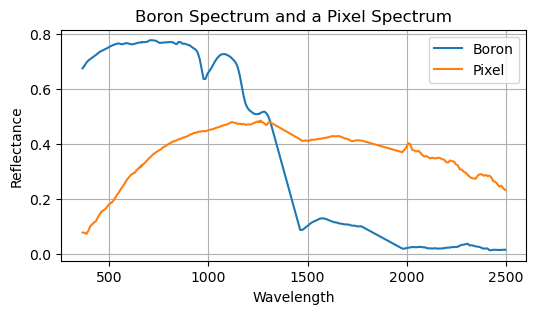

In [7]:
# Plot the target spectrum
fig = plt.figure(figsize=(6,3))
plt.plot(wl, lib.spectra[0,:], label='Boron');
plt.plot(wl, imList[1000,:].flatten(), label='Pixel');
plt.title('Boron Spectrum and a Pixel Spectrum')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance');
plt.grid(True)
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0, 0.5, 'Column (reversed)')

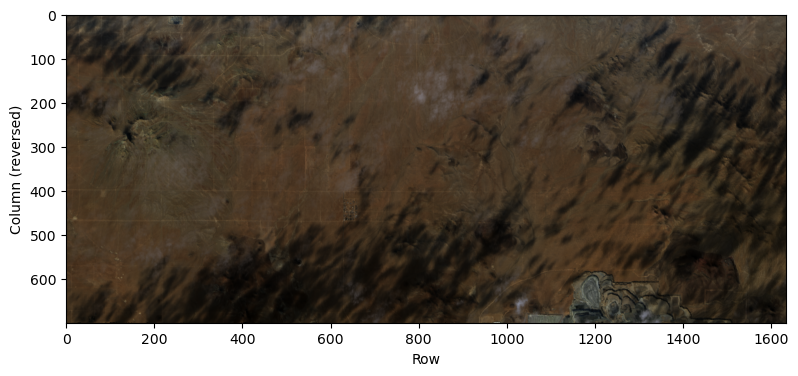

In [8]:
plt.figure(figsize=(10,4))
plt.imshow(np.rot90(imRGB))
plt.xlabel('Row')
plt.ylabel('Column (reversed)')

# Correlation Target Detection

In [9]:
def corDetect(im_arr,t):
    nRows, nCols, nBands = im_arr.shape
    nPix = nRows*nCols
    # create arrray for the output
    D = np.zeros(nPix)
    im_list = np.reshape(im_arr, (nPix, nBands))
    # normalize the target spectrum
    t_normalized = (t-np.mean(t))/np.std(t)
    # normalize the image
    im_normalized = im_list[:]
    im_mean = np.mean(im_list,axis=1)
    im_std = np.std(im_list, axis=1)
    for i in range(nBands):
        im_normalized[:,i] = (im_list[:,i] - im_mean)/(im_std+0.000001)
    # take dot product to get the correlation
    D = np.matmul(im_normalized,t_normalized)  
    D = (1/(nBands-1)) * D
    D = np.reshape(D, (nRows,nCols))
    return D    

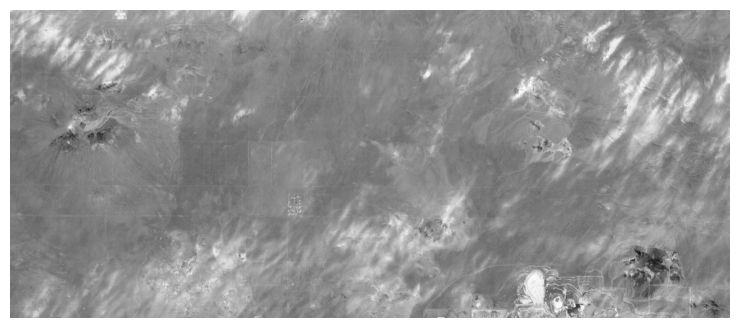

In [10]:
t = lib.spectra[0,:]
D = corDetect(imArr,t)

plt.figure(figsize=(10,4))
plt.imshow(np.rot90(D), cmap='gray')
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


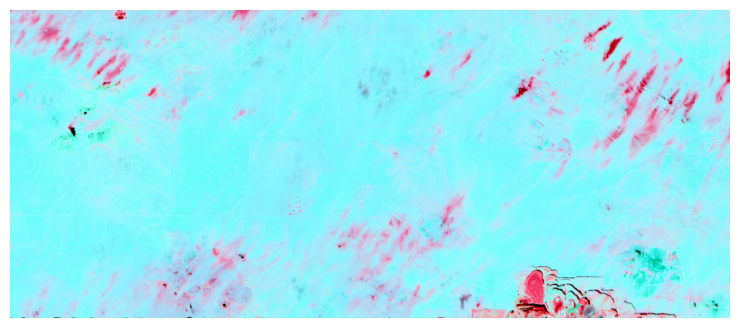

In [11]:
D = np.zeros((nRows,nCols,3))

t1 = imArr[1200,100,:].flatten()
D[:,:,0] = corDetect(imArr,t1)

t2 = imArr[200,400,:].flatten()
D[:,:,1] = corDetect(imArr,t2)

t3 = imArr[800,400,:].flatten()
D[:,:,2] = corDetect(imArr,t3)

plt.figure(figsize=(10,4))
plt.imshow(np.rot90(D))
plt.axis('off');

# ACE Target Detection

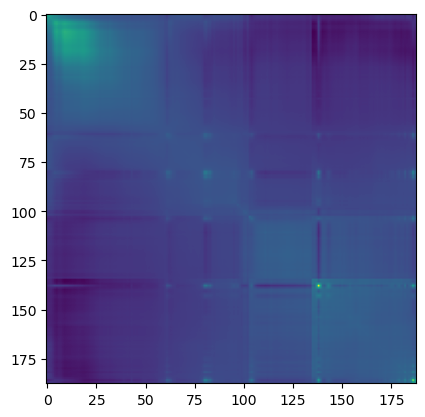

In [12]:
# Compute the mean
mu = np.mean(imList, axis=0)
# Compute the covariance
C = np.cov(imList.T)
plt.imshow(C);

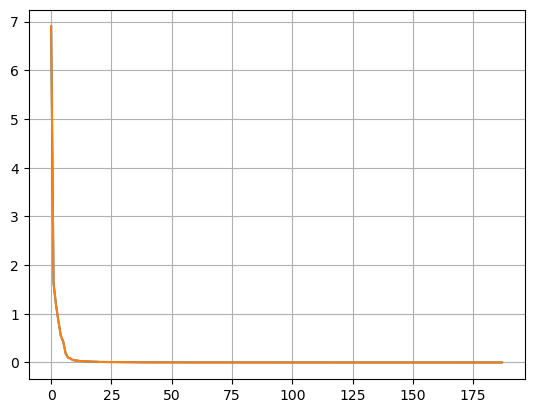

In [13]:
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the invers
plt.plot(evals)
evals[evals<10**(-8)] = 10**(-8)
plt.plot(evals)
plt.grid(True)

D = np.diag(evals**(-1/2)) # this is the squar rrot fo D^(-1) from the paper
W = np.matmul(evecs,D)

In [14]:
def aceDetect(im_arr,t):
    nRows, nCols, nBands = im_arr.shape
    nPix = nRows*nCols
    # create arrray for the output
    D = np.zeros(nPix)
    im_list = np.reshape(im_arr, (nPix, nBands))
    
    # Compute the mean
    mu = np.mean(im_list, axis=0)
    # Compute the covariance
    C = np.cov(im_list.T)
    
    evals,evecs = np.linalg.eig(C)
    # truncate the small eigenvalues to stablize the inverse
    #evals[evals<10**(-4)] = 10**(-4)
    DiagMatrix = np.diag(evals**(-1/2)) # this is the squar rrot fo D^(-1) from the paper
    W = np.matmul(evecs,DiagMatrix)
    
    # normalize the target spectrum
    t_W = np.matmul(W.T,(t-mu))
    
    # normalize the image
    im_demean = np.zeros((nPix, nBands))
    # Subtract the mean from each spectra in the library
    for i in range(nBands):
        im_demean[:,i] = im_list[:,i]-mu[i]
    im_W = np.matmul(W.T,im_demean.T).T        
        
    # take dot product to get the correlation
    denom = np.sqrt(np.sum(im_W.T**2, axis=0)) * np.sqrt(np.sum(t_W**2))
    numerator = np.matmul(im_W,t_W)
    D = numerator / denom
    D = np.reshape(D, (nRows,nCols))
    return D  

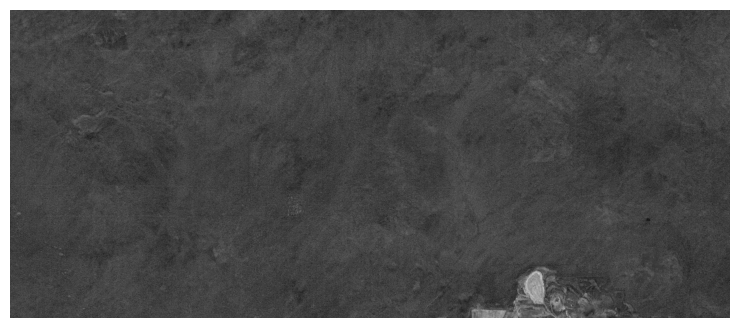

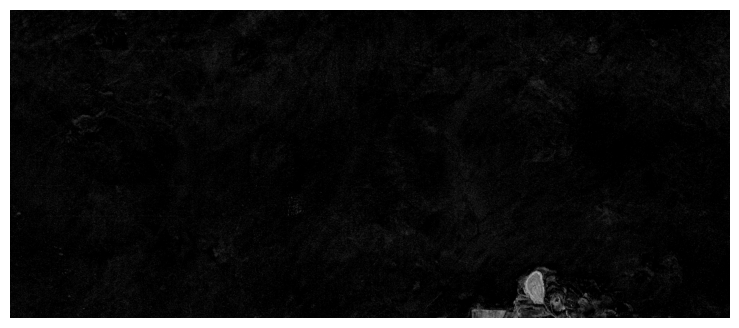

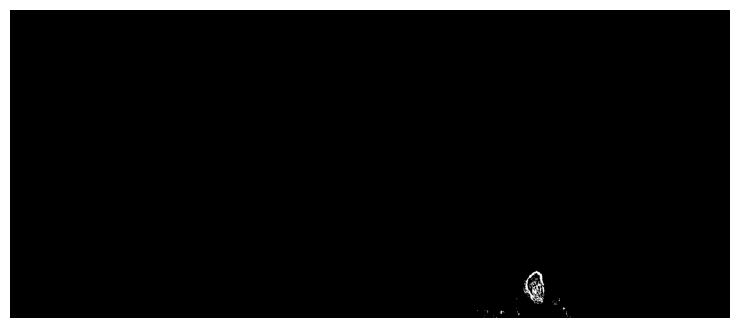

In [15]:
t1 = imArr[1200,100,:].flatten()
D = aceDetect(imArr,t1)

plt.figure(figsize=(10,4))
plt.imshow(np.rot90(D), cmap='gray')
plt.axis('off');

D[D<0] = 0
plt.figure(figsize=(10,4))
plt.imshow(np.rot90(D), cmap='gray')
plt.axis('off');

Dt = D>0.5
plt.figure(figsize=(10,4))
plt.imshow(np.rot90(Dt), cmap='gray')
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


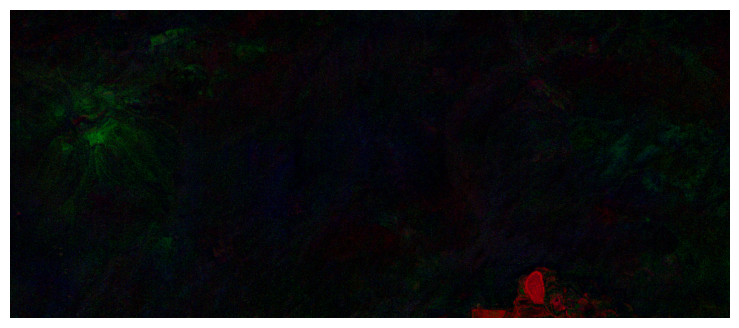

In [16]:
D = np.zeros((nRows,nCols,3))

t1 = imArr[1200,100,:].flatten()
D[:,:,0] = aceDetect(imArr,t1)

t2 = imArr[200,400,:].flatten()
D[:,:,1] = aceDetect(imArr,t2)

t3 = imArr[800,400,:].flatten()
D[:,:,2] = aceDetect(imArr,t3)

plt.figure(figsize=(10,4))
plt.imshow(np.rot90(D))
plt.axis('off');

# Create a shape file from the detection threshold

In [17]:
fnameTiff = 'temp_geotiff.tiff'

[nrows,ncols] = np.shape(Dt)
img = Dt.astype(np.uint8)


gdal.UseExceptions()
gdal_obj = gdal.Open(fname)
gt = gdal_obj.GetGeoTransform()
driver = gdal.GetDriverByName("GTiff")
dest = driver.Create(fnameTiff, img.shape[1], img.shape[0], 4, gdal.GDT_Byte)

dest.GetRasterBand(1).WriteArray(img*255)
dest.GetRasterBand(2).WriteArray(img*0)
dest.GetRasterBand(3).WriteArray(img*0)
dest.GetRasterBand(4).WriteArray(img*255)
dest.GetRasterBand(1).SetRasterColorInterpretation(gdal.GCI_RedBand)
dest.GetRasterBand(2).SetRasterColorInterpretation(gdal.GCI_GreenBand)
dest.GetRasterBand(3).SetRasterColorInterpretation(gdal.GCI_BlueBand)
dest.GetRasterBand(4).SetRasterColorInterpretation(gdal.GCI_AlphaBand)

# Set transform and projection
dest.SetGeoTransform(gt)
wkt = gdal_obj.GetProjection()
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
dest.SetProjection(srs.ExportToWkt())
dest = None

In [21]:

fnameTiff = 'temp_geotiff.tiff'
output_file = 'output_shape.shp'
if os.path.exists(output_file):
  os.remove(output_file)
  
raster = gdal.Open(fnameTiff) #osgeo.gdal.Dataset
band = raster.GetRasterBand(1) #osgeo.gdal.Band
b = band.ReadAsArray() # numpy array

proj = raster.GetProjection() # get the projection from the raster fils
shp_proj = osr.SpatialReference() # create a spatial reference for the shapefile
shp_proj.ImportFromWkt(proj) # add the projection from the raster to the shapefils

call_drive = ogr.GetDriverByName("ESRI Shapefile")
create_shp = call_drive.CreateDataSource(output_file)
shp_layer = create_shp.CreateLayer("layer_name", srs = shp_proj)
new_field = ogr.FieldDefn(str('ID'), ogr.OFTInteger)
shp_layer.CreateField(new_field)

gdal.Polygonize(band, band, shp_layer, 0, [], callback=None)
create_shp.Destroy()
raster = None

In [19]:
if False:
    create_shp.Destroy()
    raster = None

In [20]:
import geopandas as gpd
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

plot_shapefile = False
if plot_shapefile:
    sf = shp.Reader(output_file)

    plt.figure(figsize=(12,6))
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)
    plt.show()

    lucl = gpd.read_file(output_file)
    lucl.plot()

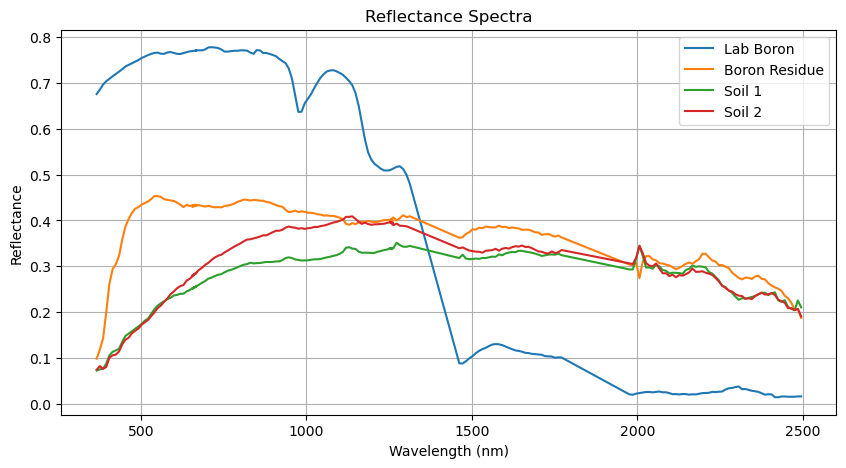

In [44]:


p1 = imArr[1200,100,:].flatten()
p2 = imArr[200,400,:].flatten()
p3 = imArr[800,400,:].flatten()

t = spec[0,:].flatten()

plt.figure(figsize=(10,5))
plt.plot(wl, t, label='Lab Boron')
plt.plot(wl, p1, label='Boron Residue')
plt.plot(wl, p2, label='Soil 1')
plt.plot(wl, p3, label='Soil 2')

plt.grid(True)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.title('Reflectance Spectra');

In [35]:
def display_RGB(imArr, wl, rotate=False):
    
    # determine the indices for the red, green, and blue bands
    red_band_idx = np.argmin(np.abs(wl-640))
    green_band_idx = np.argmin(np.abs(wl-550))
    blue_band_idx = np.argmin(np.abs(wl-460))
    
    
    # Create a numpy array for the RGB image with shape (nrows, ncold, 3)
    imRGB = imArr[:,:,[red_band_idx, green_band_idx, blue_band_idx]]
    
    # Clip the bands
    imRGB_clipped = imArr[:,:,[red_band_idx, green_band_idx, blue_band_idx]]
    for i in range(3):
        # Create a variable to hold a single band from the image. 
        # This is not the most computationally efficient method, but simplifies the code.
        single_band = imRGB_clipped[:,:,i]
        # Clip the band
        lower_thresh = np.percentile(single_band.flatten(), 2)
        single_band[single_band < lower_thresh] = lower_thresh
        upper_thresh = np.percentile(single_band.flatten(), 98)
        single_band[single_band > upper_thresh] = upper_thresh
        # Rescale to [0,1].
        single_band = single_band - lower_thresh
        single_band = single_band / np.max(single_band)
        # Put the values for this band back into the RGB image.
        imRGB_clipped[:,:,i] = single_band
    
    # Plot the clipped and rescaled image.
    plt.figure(figsize=(15,5)) 
    if rotate:
        plt.imshow(np.flip(np.rot90(imRGB_clipped), axis=0))
        plt.gca().invert_yaxis()
    else:
        plt.imshow(imRGB_clipped)
        plt.ylabel('Row');
        plt.xlabel('Column');

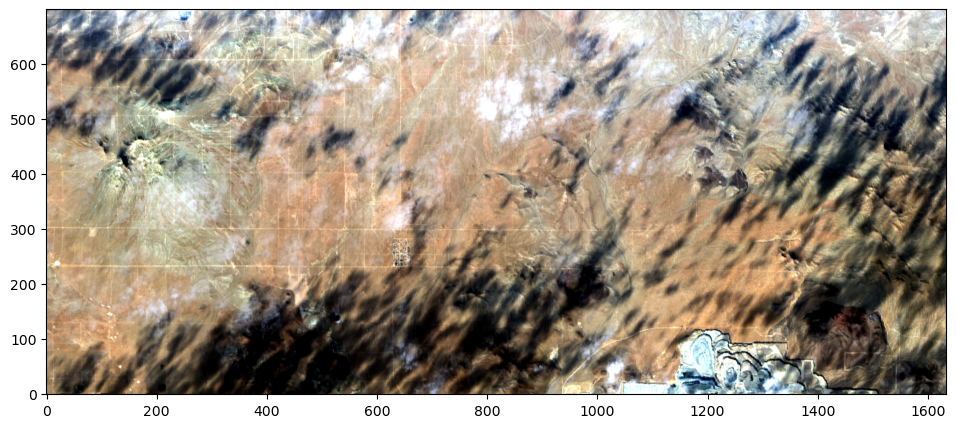

In [36]:
display_RGB(imArr, np.array(wl), rotate=True)